In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3 
def build_dataset(words):  
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   
Xdev, Ydev = build_dataset(words[n1:n2])  
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP Review


In [76]:
# good ones, the naive one is followed later
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) * 0

# baatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [62]:
Xtr.shape

torch.Size([182625, 3])

In [63]:
max_steps = 20000
batch_size = 32
lossi = []

In [77]:

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 #+ b1 
    
    
    # BatchNorm layer
    # -------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    
    
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/  20000: 3.3147
    100/  20000: 2.4222
    200/  20000: 2.8362
    300/  20000: 2.5838
    400/  20000: 2.5099
    500/  20000: 2.7987
    600/  20000: 2.4470
    700/  20000: 2.4766
    800/  20000: 2.3610
    900/  20000: 2.1361
   1000/  20000: 2.1945
   1100/  20000: 2.2817
   1200/  20000: 2.6710
   1300/  20000: 2.7380
   1400/  20000: 2.3078
   1500/  20000: 2.3958
   1600/  20000: 2.6015
   1700/  20000: 2.3745
   1800/  20000: 2.3172
   1900/  20000: 2.3646
   2000/  20000: 2.3061
   2100/  20000: 2.4367
   2200/  20000: 1.9582
   2300/  20000: 2.4397
   2400/  20000: 2.8702
   2500/  20000: 2.3725
   2600/  20000: 2.3520
   2700/  20000: 2.1794
   2800/  20000: 2.2166
   2900/  20000: 2.2390
   3000/  20000: 2.2337
   3100/  20000: 2.5820
   3200/  20000: 2.2044
   3300/  20000: 2.2671
   3400/  20000: 2.2901
   3500/  20000: 2.4187
   3600/  20000: 2.0603
   3700/  20000: 2.1360
   3800/  20000: 2.3896
   3900/  20000: 2.3852
   4000/  20000: 2.1661
   4100/  20000:

In [28]:
hpreact.shape, h.shapebb

(torch.Size([182625, 200]), torch.Size([32, 200]))

In [33]:
hpreact.view(-1).tolist()[:10]

[-3.3527133464813232,
 1.1798368692398071,
 -0.6478926539421082,
 1.5504176616668701,
 0.7601938843727112,
 0.5943890810012817,
 1.925850749015808,
 -0.5160358548164368,
 -0.7210028767585754,
 0.33796998858451843]

In [32]:
h.view(-1).tolist()[:10]

[0.39484527707099915,
 -0.3920731842517853,
 -0.5789032578468323,
 0.15651440620422363,
 0.04293053597211838,
 -0.35242608189582825,
 -0.48185592889785767,
 -0.6497335433959961,
 0.6438459157943726,
 0.7209550142288208]

(array([252., 176., 161., 120., 125., 129., 117., 154., 129., 138., 106.,
        105., 127., 101.,  95., 126.,  83., 112., 108.,  96., 108., 141.,
        129., 137., 168., 137., 131., 118., 106., 127., 135., 121., 100.,
        141., 103., 104., 114., 126., 132.,  74.,  62., 126., 134., 135.,
         98., 103., 147., 140., 177., 266.]),
 array([-9.99369264e-01, -9.59386705e-01, -9.19404147e-01, -8.79421588e-01,
        -8.39439030e-01, -7.99456471e-01, -7.59473913e-01, -7.19491354e-01,
        -6.79508796e-01, -6.39526237e-01, -5.99543679e-01, -5.59561120e-01,
        -5.19578562e-01, -4.79596003e-01, -4.39613445e-01, -3.99630886e-01,
        -3.59648328e-01, -3.19665769e-01, -2.79683211e-01, -2.39700652e-01,
        -1.99718094e-01, -1.59735535e-01, -1.19752977e-01, -7.97704184e-02,
        -3.97878599e-02,  1.94698572e-04,  4.01772571e-02,  8.01598155e-02,
         1.20142374e-01,  1.60124933e-01,  2.00107491e-01,  2.40090050e-01,
         2.80072608e-01,  3.20055166e-01,  3.60037

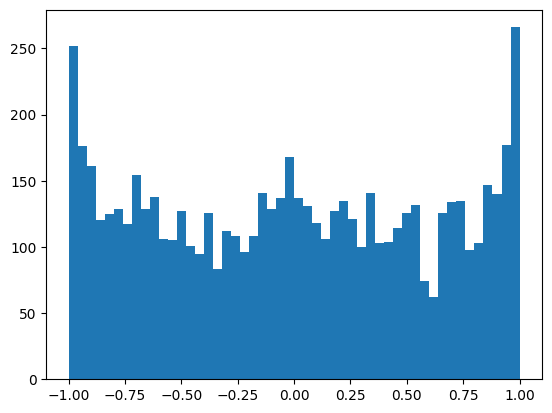

In [41]:
plt.hist(h.view(-1).tolist(), 50)
# in tanh, everything is being "squashed and rearranged"

(array([  3.,   0.,   0.,   1.,   2.,   5.,   2.,   7.,  11.,  16.,  27.,
         49.,  49.,  81.,  96., 116., 142., 192., 239., 252., 330., 382.,
        422., 469., 440., 432., 392., 381., 386., 314., 277., 197., 173.,
        124., 104.,  89.,  56.,  54.,  27.,  20.,  13.,   4.,  10.,   7.,
          2.,   2.,   1.,   1.,   0.,   1.]),
 array([-4.42725611, -4.24895202, -4.07064793, -3.89234384, -3.71403975,
        -3.53573565, -3.35743156, -3.17912747, -3.00082338, -2.82251929,
        -2.6442152 , -2.46591111, -2.28760702, -2.10930293, -1.93099884,
        -1.75269475, -1.57439066, -1.39608657, -1.21778248, -1.03947839,
        -0.8611743 , -0.68287021, -0.50456612, -0.32626203, -0.14795794,
         0.03034616,  0.20865025,  0.38695434,  0.56525843,  0.74356252,
         0.92186661,  1.1001707 ,  1.27847479,  1.45677888,  1.63508297,
         1.81338706,  1.99169115,  2.16999524,  2.34829933,  2.52660342,
         2.70490751,  2.8832116 ,  3.06151569,  3.23981978,  3.41812387,
 

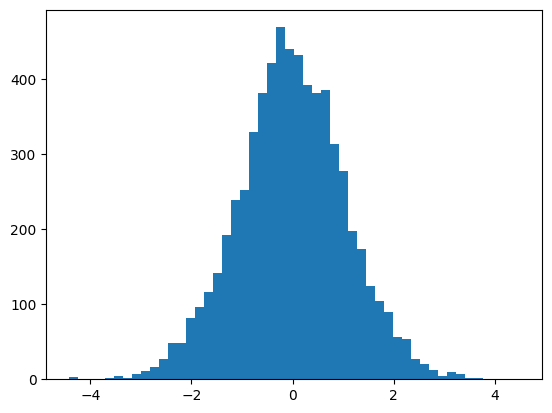

In [78]:
plt.hist(hpreact.view(-1).tolist()[:10000], 50)

# hpreact is only -4 to 4, better than the worse/latter version

In [19]:
# seperate stuff
# 1/27 initial chance of being chosen for any character
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [26]:
# seperate stuff

logits = torch.randn(4)
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

# therefore, things could have gone wrong if the first losses are much higher than 3.2958

(tensor([ 1.2946,  0.4244,  1.4995, -0.2296]),
 tensor([0.3492, 0.1463, 0.4285, 0.0760]),
 tensor(0.8474))

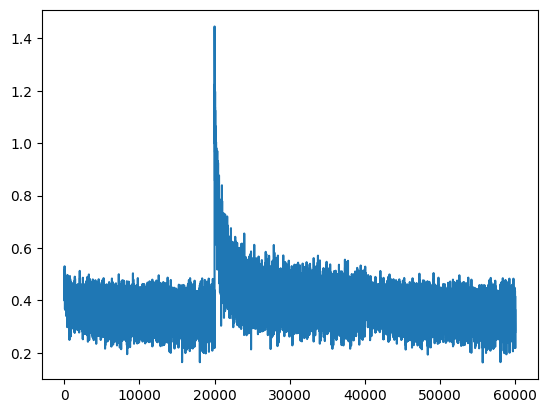

In [79]:
plt.plot(lossi)

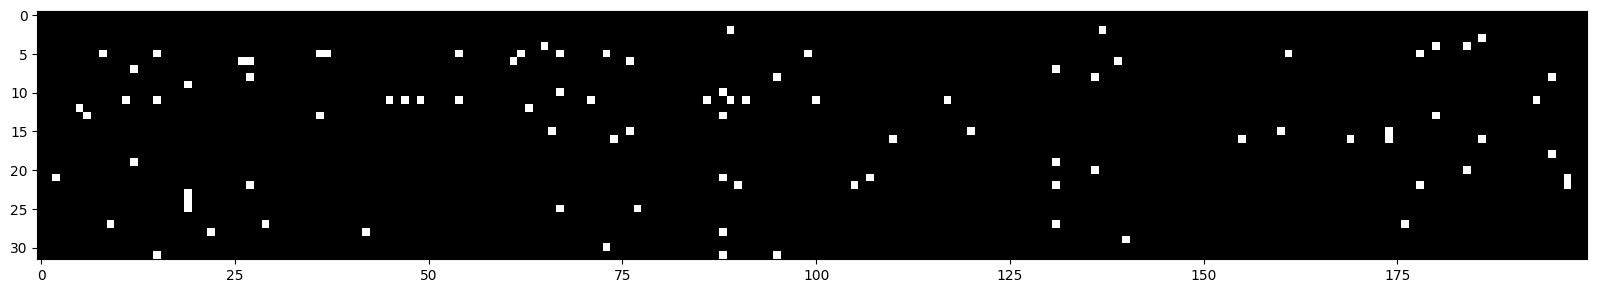

In [80]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = "nearest")
# if it is a white dot, it means that dot is near the tail and has been activated. 
# a column is all white, it is a dead neuron. 
# choosing 0.99 here, because it means towards the tail,  
# if a nueron gets the result in the tails, for the flat part of an activation, it is inactive afterwards... 
# it does not have gradient pass through, and it probably will never be reactivated again in the future. sooo... 
# it is kind of like brain damage.
# we should avoid this kind of gradient 

In [81]:
# MLP revisited
# worse version

# a worse version, b1, b1, b2, w2 are not close to 0
# the first loss is going to be huge


n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) 
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) 

# baatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2,]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [82]:
for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1 
    
    
    # BatchNorm layer
    # -------------------------------------------------------
#     bnmeani = hpreact.mean(0, keepdim=True)
#     bnstdi = hpreact.std(0, keepdim=True)
#     hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
#     # -------------------------------------------
#     # Non-linearity
#     h = torch.tanh(hpreact) 
#     logits = h @ W2 + b2 
#     loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 200 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/  20000: 27.8817
    200/  20000: 8.7435
    400/  20000: 3.6911
    600/  20000: 4.2153
    800/  20000: 5.2333
   1000/  20000: 4.0903
   1200/  20000: 4.0933
   1400/  20000: 3.1122
   1600/  20000: 3.7591
   1800/  20000: 3.4161
   2000/  20000: 2.9773
   2200/  20000: 2.6979
   2400/  20000: 3.5182
   2600/  20000: 3.0858
   2800/  20000: 3.0245
   3000/  20000: 2.9625
   3200/  20000: 2.7569
   3400/  20000: 3.0178
   3600/  20000: 2.5338
   3800/  20000: 2.7519
   4000/  20000: 2.3263
   4200/  20000: 2.9018
   4400/  20000: 2.5059
   4600/  20000: 2.2889
   4800/  20000: 2.7963
   5000/  20000: 2.3998
   5200/  20000: 2.9633
   5400/  20000: 3.1338
   5600/  20000: 3.3486
   5800/  20000: 2.6856
   6000/  20000: 2.3728
   6200/  20000: 3.3100
   6400/  20000: 3.0872
   6600/  20000: 2.9549
   6800/  20000: 2.7653
   7000/  20000: 2.7671
   7200/  20000: 2.2756
   7400/  20000: 2.2455
   7600/  20000: 3.0820
   7800/  20000: 2.1984
   8000/  20000: 2.4620
   8200/  20000

(array([2081.,  230.,  143.,  100.,   47.,   37.,   45.,   27.,   41.,
          28.,   19.,   17.,   22.,   23.,   20.,   15.,   24.,   16.,
          15.,   22.,   14.,   16.,   18.,   13.,   16.,   14.,   17.,
          22.,   10.,   11.,   13.,   15.,   24.,   18.,   19.,   20.,
          18.,   14.,   34.,   22.,   21.,   26.,   40.,   42.,   52.,
          70.,   65.,  108.,  253., 2403.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

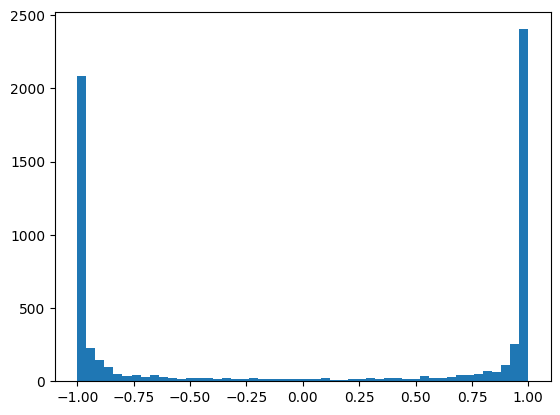

In [83]:
# h data is very extreme
plt.hist(h.view(-1).tolist(), 50)
# in tanh, everything is being "squashed and rearranged"

(array([  1.,   0.,   1.,   3.,   6.,   5.,  10.,  15.,  28.,  40.,  39.,
         65.,  86., 102., 140., 160., 198., 245., 316., 406., 413., 387.,
        273., 264., 288., 372., 429., 344., 272., 322., 284., 208., 188.,
        130., 114.,  72.,  55.,  23.,  31.,  26.,  14.,   9.,   5.,   2.,
          4.,   1.,   1.,   1.,   1.,   1.]),
 array([-15.84355545, -15.16682072, -14.49008598, -13.81335125,
        -13.13661652, -12.45988178, -11.78314705, -11.10641232,
        -10.42967758,  -9.75294285,  -9.07620811,  -8.39947338,
         -7.72273865,  -7.04600391,  -6.36926918,  -5.69253445,
         -5.01579971,  -4.33906498,  -3.66233025,  -2.98559551,
         -2.30886078,  -1.63212605,  -0.95539131,  -0.27865658,
          0.39807816,   1.07481289,   1.75154762,   2.42828236,
          3.10501709,   3.78175182,   4.45848656,   5.13522129,
          5.81195602,   6.48869076,   7.16542549,   7.84216022,
          8.51889496,   9.19562969,   9.87236443,  10.54909916,
         11.225833

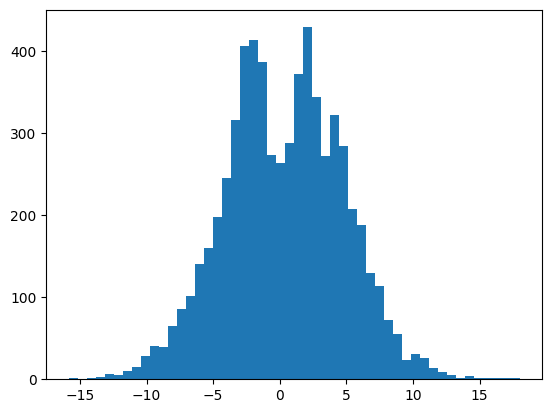

In [84]:
# hpreact is also toooo broad (-15 to 15)
plt.hist(hpreact.view(-1).tolist(), 50)

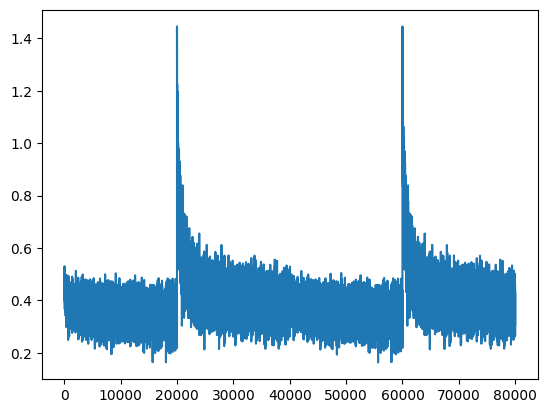

In [85]:
plt.plot(lossi)

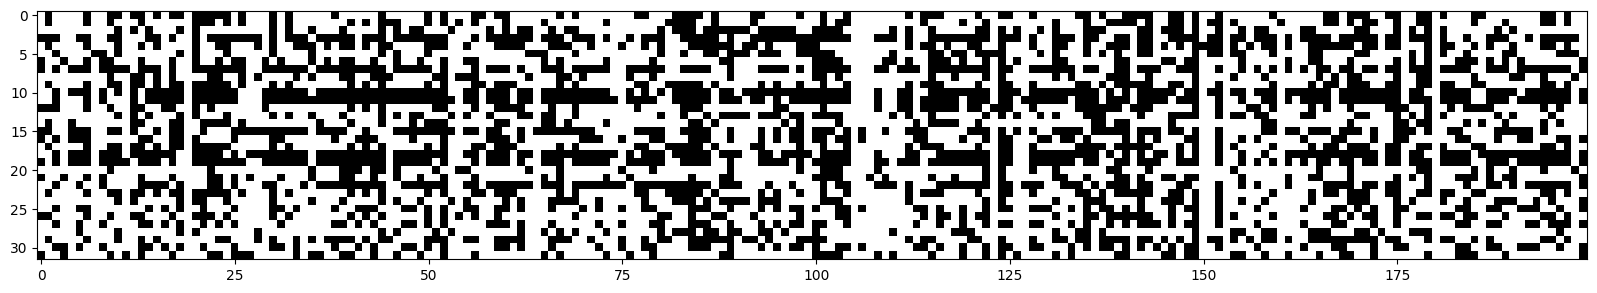

In [87]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = "nearest")





# here: we have some dead neurons (where the whole columns are white)

tensor(-0.0015) tensor(1.0059)
tensor(0.0061) tensor(3.2053)


(array([6.31251982e-06, 2.52500793e-05, 0.00000000e+00, 6.31251982e-06,
        2.52500793e-05, 5.68126784e-05, 5.05001585e-05, 1.45187956e-04,
        2.58813313e-04, 3.28251031e-04, 6.37564502e-04, 9.59503012e-04,
        1.69806783e-03, 3.15625991e-03, 4.86695278e-03, 8.26940096e-03,
        1.25177268e-02, 2.01053756e-02, 3.11207227e-02, 4.52102669e-02,
        6.39142632e-02, 8.34199494e-02, 1.04358578e-01, 1.22841636e-01,
        1.32247290e-01, 1.33351981e-01, 1.21269818e-01, 1.02351196e-01,
        8.18291944e-02, 6.14713180e-02, 4.40045757e-02, 3.02937826e-02,
        1.94109984e-02, 1.25619144e-02, 8.00427513e-03, 4.51976419e-03,
        2.91638416e-03, 1.86850587e-03, 9.72128052e-04, 6.31251982e-04,
        3.66126149e-04, 1.57812995e-04, 1.38875436e-04, 6.31251982e-05,
        5.05001585e-05, 1.26250396e-05, 2.52500793e-05, 0.00000000e+00,
        0.00000000e+00, 6.31251982e-06]),
 array([-19.7662735 , -18.97419678, -18.18212006, -17.39004333,
        -16.59796661, -15.8058

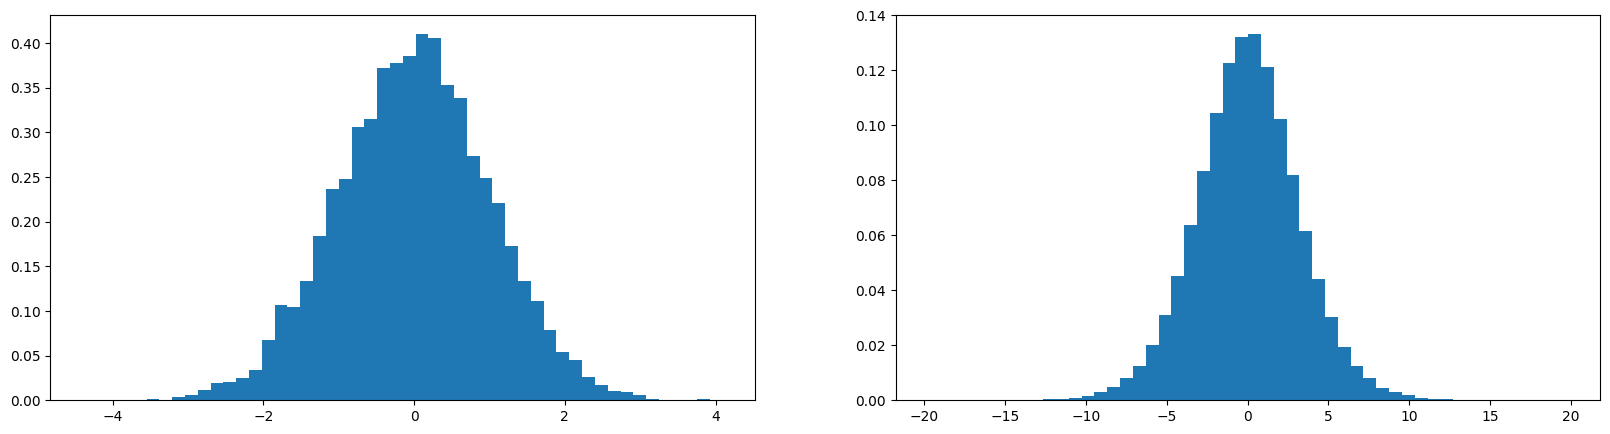

In [89]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) 
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




tensor(-0.0025) tensor(0.9987)
tensor(-0.0306) tensor(16.3898)


(array([1.31426563e-06, 1.31426563e-06, 3.94279688e-06, 3.94279688e-06,
        3.94279688e-06, 3.94279688e-06, 6.57132813e-06, 1.70854531e-05,
        2.75995781e-05, 6.30847500e-05, 1.20912438e-04, 1.59026141e-04,
        2.99652563e-04, 4.81021219e-04, 7.91187907e-04, 1.28535178e-03,
        1.89122824e-03, 3.05041052e-03, 4.45930327e-03, 6.59761344e-03,
        9.32077182e-03, 1.23554111e-02, 1.66149460e-02, 2.01884343e-02,
        2.35030122e-02, 2.59436035e-02, 2.60671444e-02, 2.43717418e-02,
        2.16827543e-02, 1.77399574e-02, 1.37827036e-02, 1.02171010e-02,
        7.37960149e-03, 5.18346363e-03, 3.38423399e-03, 2.20665199e-03,
        1.44832072e-03, 8.84500766e-04, 5.32277578e-04, 3.16738016e-04,
        1.86625719e-04, 1.24855234e-04, 7.49131407e-05, 3.41709063e-05,
        1.83997188e-05, 1.05141250e-05, 5.25706250e-06, 2.62853125e-06,
        2.62853125e-06, 1.31426563e-06]),
 array([-99.53689575, -95.73248978, -91.9280838 , -88.12367783,
        -84.31927185, -80.5148

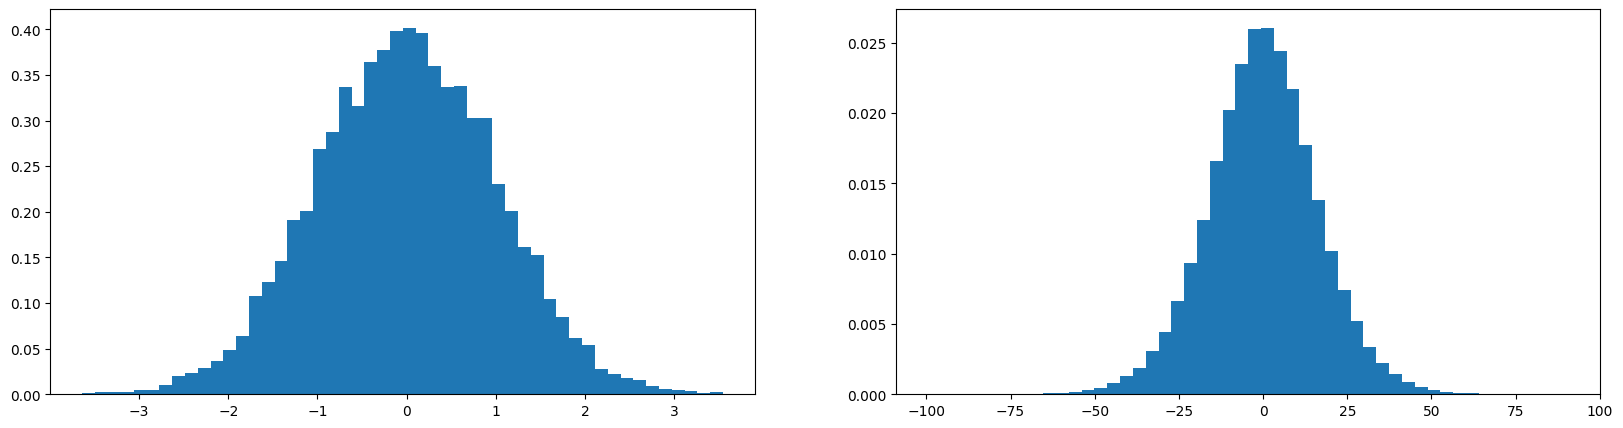

In [90]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




tensor(0.0195) tensor(1.0096)
tensor(-0.0008) tensor(0.6442)


(array([3.09140570e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.27421709e-05, 3.09140570e-05, 3.09140570e-05,
        2.47312456e-04, 2.78226513e-04, 4.63710854e-04, 1.17473416e-03,
        2.00941370e-03, 2.99866352e-03, 5.99732705e-03, 1.02943810e-02,
        1.76828406e-02, 2.84409324e-02, 4.72985071e-02, 7.42555648e-02,
        1.16700565e-01, 1.71789414e-01, 2.52258705e-01, 3.43733399e-01,
        4.49088505e-01, 5.62326696e-01, 6.34820160e-01, 6.68547396e-01,
        6.37695167e-01, 5.75774311e-01, 4.62999831e-01, 3.55295257e-01,
        2.58688829e-01, 1.80692663e-01, 1.21646814e-01, 7.86144468e-02,
        4.83495851e-02, 2.91519557e-02, 1.86720904e-02, 1.08508340e-02,
        6.02824111e-03, 3.64785872e-03, 1.70027313e-03, 1.32930445e-03,
        6.49195196e-04, 2.16398399e-04, 9.27421709e-05, 3.09140570e-05,
        6.18281139e-05, 3.09140570e-05]),
 array([-4.45684719, -4.29510847, -4.13336975, -3.97163103, -3.80989231,
        -3.64815359, 

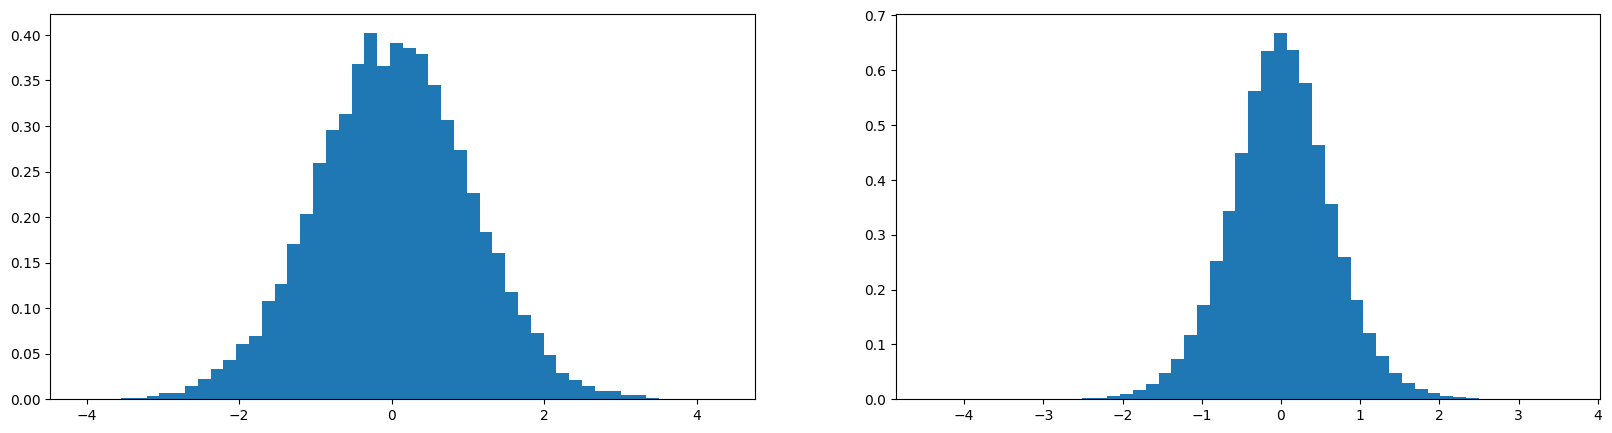

In [91]:
# shrik 
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




In [92]:
torch.randn(10000)*0.2

tensor([-0.2164,  0.1591, -0.3784,  ..., -0.0756, -0.3952, -0.3392])

In [95]:
n_embd * block_size

30

In [93]:
(torch.randn(10000)*0.2).std

<function Tensor.std>

In [99]:
# torch.nn.tanh recommendation

In [100]:
5/3 / (30**0.5)

0.3042903097250923

## Batch Normalization 



In [102]:
# 
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) * 0

# baatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


12097


In [101]:
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 
    #+ b1 b1 is wasted here, they will be subtracted out by bnmeani, and does not have effect
    # so b1 can be completely ignored. 
    
    # BatchNorm layer **************************** Here !!!!
    # -------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # offsetting by bnstdi and bnbias
    
     # center the batch using Gaussian
    
    
    with torch.no_grad():
        # inferences 
        # on top of that, we will calculate mean and varaiance 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

12097
      0/  20000: 3.3147
    100/  20000: 2.4222
    200/  20000: 2.8362
    300/  20000: 2.5838
    400/  20000: 2.5099
    500/  20000: 2.7987
    600/  20000: 2.4470
    700/  20000: 2.4766
    800/  20000: 2.3610
    900/  20000: 2.1361
   1000/  20000: 2.1945
   1100/  20000: 2.2817
   1200/  20000: 2.6710
   1300/  20000: 2.7380
   1400/  20000: 2.3078
   1500/  20000: 2.3958
   1600/  20000: 2.6015
   1700/  20000: 2.3745
   1800/  20000: 2.3172
   1900/  20000: 2.3646
   2000/  20000: 2.3061
   2100/  20000: 2.4367
   2200/  20000: 1.9582
   2300/  20000: 2.4397
   2400/  20000: 2.8702
   2500/  20000: 2.3725
   2600/  20000: 2.3520
   2700/  20000: 2.1794
   2800/  20000: 2.2166
   2900/  20000: 2.2390
   3000/  20000: 2.2337
   3100/  20000: 2.5820
   3200/  20000: 2.2044
   3300/  20000: 2.2671
   3400/  20000: 2.2901
   3500/  20000: 2.4187
   3600/  20000: 2.0603
   3700/  20000: 2.1360
   3800/  20000: 2.3896
   3900/  20000: 2.3852
   4000/  20000: 2.1661
   4100/  

In [15]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [17]:
# this decorator disables gradient tracking
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x]
    # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # batch normalization 
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/ hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2065374851226807
val 2.2185726165771484


## ResNET



In [103]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.rand((fan_in, fan_out), generator = g) /fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [104]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [105]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [109]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [111]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 200 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.5594
    200/ 200000: 2.3182
    400/ 200000: 2.9145
    600/ 200000: 2.8333
    800/ 200000: 2.3227
   1000/ 200000: 2.7448


In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')